In [1]:
!nvidia-smi

Mon Jun  1 19:12:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q -U watermark


In [3]:
!pip install -qq transformers

     |████████████████████████████████| 665kB 32.4MB/s 
     |████████████████████████████████| 1.1MB 54.1MB/s 
     |████████████████████████████████| 890kB 50.6MB/s 
     |████████████████████████████████| 3.8MB 54.3MB/s 


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
pandas 1.0.3
torch 1.5.0+cu101
transformers 2.10.0


In [0]:
#imports
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
!wget https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/data.csv?token=AFCBJTYYIMZSUMMD5SQTRK2632J7S

In [0]:
df = pd.read_csv('data.csv')

In [0]:
df = df.drop('Unnamed: 0', 1)

In [0]:
enc_classes={'joy':0,'fear':1,'anger':2,'sadness':3,'digust':4,'shame':5,'guilty':6}
class_name=['joy','fear','anger','sadness','digust','shame','guilty']

def to_number(emotion):
  emotion=str(emotion)
  return enc_classes[emotion]

df['Enc_Emotion'] = df.Emotion.apply(to_emotion)



In [65]:
df.head()

,Sentence,Emotion
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,digust


In [66]:
df.shape

(7666, 2)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7666 entries, 0 to 7665
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7666 non-null   int64 
 1   Sentence    7666 non-null   object
 2   Emotion     7666 non-null   object
dtypes: int64(1), object(2)
memory usage: 179.8+ KB


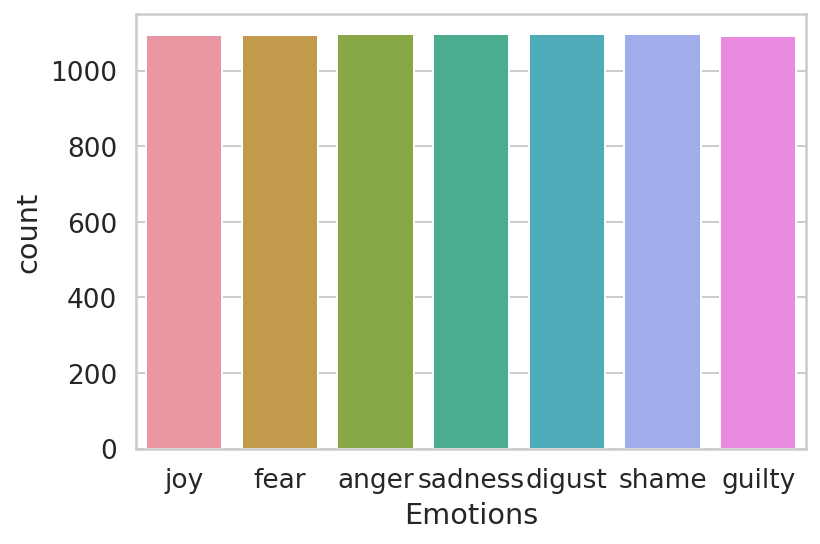

In [52]:
sns.countplot(df.Emotion)
plt.xlabel('Emotions');

Data is balanced, good

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [25]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [26]:
#SEP TOKEN : marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [27]:
#CLS TOKEN : we must add this token to the start of each sentence, so BERT knows we're doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [28]:
#PAD Token: for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [29]:
#UNK : Unknown Token
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [31]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [32]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [33]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [34]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [0]:
token_lens = []

for txt in df.Sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

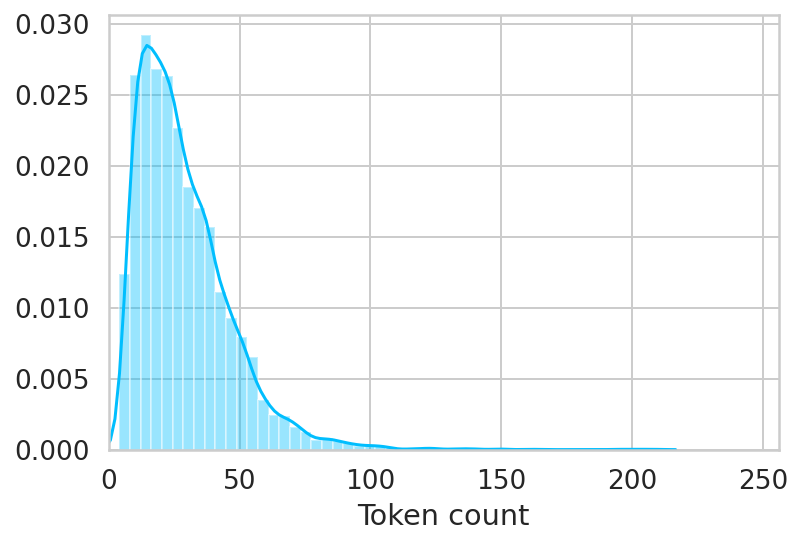

In [53]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [0]:
MAX_LEN = 120

In [0]:
class EmotionReviewDataSet(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)


In [57]:
df_train.shape, df_val.shape, df_test.shape

((6899, 3), (383, 3), (384, 3))

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = EmotionReviewDataSet(
    reviews=df.Sentence.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [62]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

AttributeError: ignored